<a href="https://colab.research.google.com/github/juanfpinzon/DeepLearning_NSU/blob/master/Home_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Dont run it is for setting working dir for Google Colab. (Cloud GPU service)
import os
os.chdir("/content/drive/My Drive/BDA - MASTER /3RD SEM/DeepLearning")

In [0]:
# Import of packages and libraries:
import pandas as pd
import xml.etree.cElementTree as et
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import gensim
from keras.layers import Input
from keras import regularizers
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import backend as K

# XML Parser:

In [0]:
def xml_parser(path):
    d = dict()
    root = et.parse(path)
    rows = root.findall('.//column')
    for row in rows:
        d.setdefault(list(row.attrib.values())[0],[]).append(row.text)
    df = pd.DataFrame.from_dict(d)
    return df

In [0]:
# Parse data:
data_train = pd.DataFrame()
data_test = pd.DataFrame()
path_train = ['tkk_train_2016.xml', 
              'bank_train_2016.xml']
path_test = ['tkk_test_etalon.xml',
             'banks_test_etalon.xml']
for path in path_train:
    df = xml_parser(path)
    data_train = pd.concat([df, data_train], ignore_index=True)
for path in path_test:
    df = xml_parser(path)
    data_test = pd.concat([df, data_test], ignore_index=True)


In [9]:
data_train

,alfabank,bankmoskvy,beeline,date,gazprom,id,komstar,megafon,mts,raiffeisen,rostelecom,rshb,sberbank,skylink,tele2,text,twitid,uralsib,vtb
0,0,NULL,NaN,1406224554,NULL,1,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,492367586156630000,NULL,NULL
1,NULL,NULL,NaN,1406224691,NULL,2,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,Мнение о кредитной карте втб 24 http://t.co/SB...,492368160923070000,NULL,0
2,NULL,NULL,NaN,1406224798,NULL,3,NaN,NaN,NaN,0,NaN,NULL,NULL,NaN,NaN,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,492368608346260000,NULL,NULL
3,NULL,NULL,NaN,1406225412,NULL,4,NaN,NaN,NaN,NULL,NaN,NULL,0,NaN,NaN,Современное состояние кредитного поведения в р...,492371181946030000,NULL,NULL
4,NULL,NULL,NaN,1406226283,NULL,5,NaN,NaN,NaN,NULL,NaN,NULL,1,NaN,NaN,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,492374836564750000,NULL,1
5,NULL,0,NaN,1406226450,NULL,6,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/Qr6JbSVTxY Оформить краткосрочный ...,492375537080600000,NULL,NULL
6,NULL,NULL,NaN,1406226505,NULL,7,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,Самый выгодный автокредит в втб 24 http://t.co...,492375766907510000,NULL,1
7,NULL,NULL,NaN,1406226960,NULL,9,NaN,NaN,NaN,NULL,NaN,NULL,0,NaN,NaN,Кредит иногородним в москве сбербанк http://t....,492377674535680000,NULL,NULL
8,NULL,NULL,NaN,1406226982,NULL,10,NaN,NaN,NaN,NULL,NaN,0,NULL,NaN,NaN,Кредитный калькулятор россельхозбанк чита http...,492377768232250000,NULL,NULL
9,NULL,NULL,NaN,1406227218,NULL,11,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/h6r6GdBe4H Легко можно получить де...,492378757769220000,NULL,1


# Data Preparation:

In [10]:
data_train.drop(['date', 'id', 'twitid'], axis=1, inplace = True, errors='ignore')
data_train.head()

,alfabank,bankmoskvy,beeline,gazprom,komstar,megafon,mts,raiffeisen,rostelecom,rshb,sberbank,skylink,tele2,text,uralsib,vtb
0,0,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,NULL,NULL
1,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,Мнение о кредитной карте втб 24 http://t.co/SB...,NULL,0
2,NULL,NULL,NaN,NULL,NaN,NaN,NaN,0,NaN,NULL,NULL,NaN,NaN,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,NULL,NULL
3,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,0,NaN,NaN,Современное состояние кредитного поведения в р...,NULL,NULL
4,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,1,NaN,NaN,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,NULL,1


In [11]:
data_train.fillna(0)

,alfabank,bankmoskvy,beeline,gazprom,komstar,megafon,mts,raiffeisen,rostelecom,rshb,sberbank,skylink,tele2,text,uralsib,vtb
0,0,NULL,0,NULL,0,0,0,NULL,0,NULL,NULL,0,0,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,NULL,NULL
1,NULL,NULL,0,NULL,0,0,0,NULL,0,NULL,NULL,0,0,Мнение о кредитной карте втб 24 http://t.co/SB...,NULL,0
2,NULL,NULL,0,NULL,0,0,0,0,0,NULL,NULL,0,0,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,NULL,NULL
3,NULL,NULL,0,NULL,0,0,0,NULL,0,NULL,0,0,0,Современное состояние кредитного поведения в р...,NULL,NULL
4,NULL,NULL,0,NULL,0,0,0,NULL,0,NULL,1,0,0,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,NULL,1
5,NULL,0,0,NULL,0,0,0,NULL,0,NULL,NULL,0,0,http://t.co/Qr6JbSVTxY Оформить краткосрочный ...,NULL,NULL
6,NULL,NULL,0,NULL,0,0,0,NULL,0,NULL,NULL,0,0,Самый выгодный автокредит в втб 24 http://t.co...,NULL,1
7,NULL,NULL,0,NULL,0,0,0,NULL,0,NULL,0,0,0,Кредит иногородним в москве сбербанк http://t....,NULL,NULL
8,NULL,NULL,0,NULL,0,0,0,NULL,0,0,NULL,0,0,Кредитный калькулятор россельхозбанк чита http...,NULL,NULL
9,NULL,NULL,0,NULL,0,0,0,NULL,0,NULL,NULL,0,0,http://t.co/h6r6GdBe4H Легко можно получить де...,NULL,1


# Get Labels:

In [0]:
def label(row):
    if (row == '1').any():
        label = 1
    elif (row == '0').any():
            label = 0
    else:
        label = -1
    return(label)

In [13]:
data_train['label'] = data_train.apply(label, axis=1)
data_train.label.value_counts()

 0    11832
-1     4145
 1     2058
Name: label, dtype: int64

In [14]:
data_test['label'] = data_test.apply(label, axis=1)
data_test.label.value_counts()

 0    3251
-1    1769
 1     540
Name: label, dtype: int64

# Clean Text:

In [0]:
def clean_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [0]:
data_train['clean_text'] = data_train.text.apply(clean_text)
data_test['clean_text'] = data_test.text.apply(clean_text)

In [17]:
data_train

,alfabank,bankmoskvy,beeline,gazprom,komstar,megafon,mts,raiffeisen,rostelecom,rshb,sberbank,skylink,tele2,text,uralsib,vtb,label,clean_text
0,0,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,NULL,NULL,0,URL взять кредит тюмень альфа банк
1,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,Мнение о кредитной карте втб 24 http://t.co/SB...,NULL,0,0,мнение о кредитной карте втб 24 URL
2,NULL,NULL,NaN,NULL,NaN,NaN,NaN,0,NaN,NULL,NULL,NaN,NaN,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,NULL,NULL,0,райффайзенбанк снижение ключевой ставки цб на ...
3,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,0,NaN,NaN,Современное состояние кредитного поведения в р...,NULL,NULL,0,современное состояние кредитного поведения в р...
4,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,1,NaN,NaN,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,NULL,1,1,USER USER главное чтоб банки сбер и втб
5,NULL,0,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/Qr6JbSVTxY Оформить краткосрочный ...,NULL,NULL,0,URL оформить краткосрочный кредит оао банк москвы
6,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,Самый выгодный автокредит в втб 24 http://t.co...,NULL,1,1,самый выгодный автокредит в втб 24 URL
7,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,0,NaN,NaN,Кредит иногородним в москве сбербанк http://t....,NULL,NULL,0,кредит иногородним в москве сбербанк URL
8,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,0,NULL,NaN,NaN,Кредитный калькулятор россельхозбанк чита http...,NULL,NULL,0,кредитный калькулятор россельхозбанк чита URL
9,NULL,NULL,NaN,NULL,NaN,NaN,NaN,NULL,NaN,NULL,NULL,NaN,NaN,http://t.co/h6r6GdBe4H Легко можно получить де...,NULL,1,1,URL легко можно получить денежный кредит ы втб...


# TF-IDF Vectorizer: 

In [18]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(data_train.text)
X_train.shape

(18035, 35957)

In [19]:
X_test = vectorizer.transform(data_test.text)
X_test.shape

(5560, 35957)

# Word2Vec:

In [0]:
# Merge train & test data:
data = pd.concat([data_train, data_test], ignore_index=True)

# Split text:
split_text = data.clean_text.apply(lambda sent: sent.lower().split())

## Training W2V on tweet texts:

In [0]:
w2v = gensim.models.Word2Vec(sentences=split_text, sg=1, min_count=1)

In [22]:
# Check # of unique words:
keys = len(list(w2v.wv.vocab.keys()))
keys

28652

In [23]:
split_text.apply(lambda row: len(row)).value_counts()

6     2386
7     1937
8     1876
5     1848
9     1681
10    1463
11    1411
12    1085
13    1040
16     947
17     927
14     911
15     903
18     880
19     783
20     713
4      696
21     601
22     426
23     312
3      212
24     203
25     116
2       95
26      75
27      33
28      16
29       8
1        5
30       4
32       2
Name: clean_text, dtype: int64

## Transforming Data:

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.clean_text)
X_train = tokenizer.texts_to_sequences(data_train.clean_text)
X_test = tokenizer.texts_to_sequences(data_test.clean_text)

In [0]:
X_train = pad_sequences(X_train, maxlen=30)
X_test = pad_sequences(X_test, maxlen=30)

In [26]:
X_train

array([[    0,     0,     0, ...,   924,    31,    14],
       [    0,     0,     0, ...,    13,    26,     1],
       [    0,     0,     0, ...,  1996,   208, 13012],
       ...,
       [    0,     0,     0, ...,    20,   601,   532],
       [    0,     0,     0, ...,    20,   601,   532],
       [    0,     0,     0, ...,    20,   601,   532]], dtype=int32)

## Embedding Matrix:

In [0]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
vec = []
for word, i in tokenizer.word_index.items():
    if word in w2v.wv.vocab:
        embedding_vector = w2v.wv.get_vector(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        vec.append(word)

In [28]:
embedding_matrix.shape

(28653, 100)

## Validation Data:

In [0]:
y = to_categorical(data_train.label.as_matrix()+1)
y_val = y[:7000]
partial_y_train = y[7000:]

x_val = X_train[:7000]
partial_x_train = X_train[7000:]


## CNN Model:

In [0]:
n = 30
tweet_input = Input(shape=(n,), dtype='int32')
inp = Embedding(keys+1, 100, input_length=n,
                weights=[embedding_matrix], trainable=False)(tweet_input)

In [0]:
#del branches

In [32]:
branches = []

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        # Add Conv. layer
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(inp)
        # Subsampling layer
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1) 
drop_1 = Dropout(0.2)(x)

# Now flatten to 1D, apply FC > Softmax (with dropout) > softmax
hidden = Dense(30, activation='relu')(drop_1)
drop_3 = Dropout(0.2)(hidden)
out = Dense(3, activation='softmax')(drop_3)

# Initiate Model
model = Model(input=tweet_input, output=out) 

# Compile Model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      2865300     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29, 1)        201         embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 29, 1)        201         embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [33]:
%%time
# Fit Model
history = model.fit([partial_x_train], partial_y_train,
                    verbose=1, epochs=100, batch_size=128, validation_data=(x_val, y_val))

Train on 11035 samples, validate on 7000 samples
Epoch 1/100
11035/11035 [==============================] - 9s 784us/step - loss: 0.8691 - acc: 0.6163 - val_loss: 0.6869 - val_acc: 0.7306
Epoch 2/100
11035/11035 [==============================] - 5s 456us/step - loss: 0.7760 - acc: 0.6631 - val_loss: 0.7016 - val_acc: 0.7374
Epoch 3/100
11035/11035 [==============================] - 5s 451us/step - loss: 0.7483 - acc: 0.6763 - val_loss: 0.6998 - val_acc: 0.7399
Epoch 4/100
11035/11035 [==============================] - 5s 448us/step - loss: 0.7285 - acc: 0.6829 - val_loss: 0.6783 - val_acc: 0.7459
Epoch 5/100
11035/11035 [==============================] - 5s 449us/step - loss: 0.7115 - acc: 0.6852 - val_loss: 0.6564 - val_acc: 0.7499
Epoch 6/100
11035/11035 [==============================] - 5s 442us/step - loss: 0.7031 - acc: 0.6892 - val_loss: 0.6538 - val_acc: 0.7504
Epoch 7/100
11035/11035 [==============================] - 5s 456us/step - loss: 0.6917 - acc: 0.6963 - val_loss: 0.6

##Plotting Loss & Accuracy

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

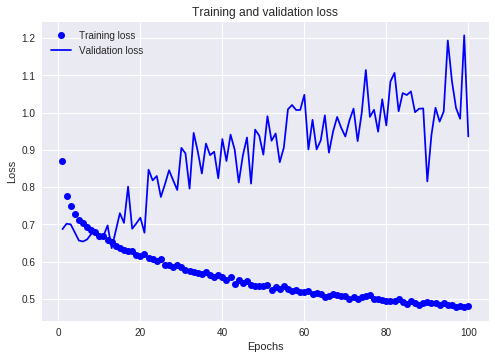

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

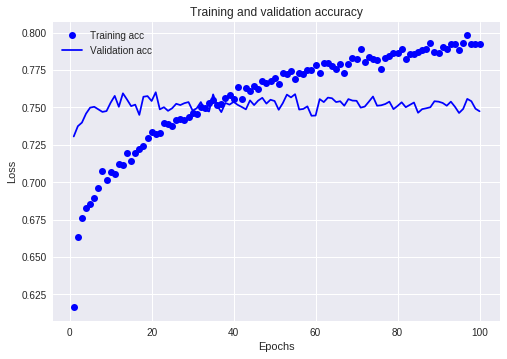

In [40]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 79.81875849515538 Epoch: 96 Best Validation Accuracy: 76.01428574153356 Epoch: 20
Lowest Training Loss value: 47.731438878439214 Epoch: 96 Lowest Validation Loss: 63.5777775151389 Epoch: 12


## Results(Best Model):

In [0]:
# Some memory clean-up
K.clear_session()

In [0]:
n = 30
tweet_input = Input(shape=(n,), dtype='int32')
inp = Embedding(keys+1, 100, input_length=n,
                weights=[embedding_matrix], trainable=False)(tweet_input)

In [44]:
branches = []

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        # Add Conv. layer
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(inp)
        # Subsampling layer
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1) 
drop_1 = Dropout(0.2)(x)

# Now flatten to 1D, apply FC > Softmax (with dropout) > softmax
hidden = Dense(30, activation='relu')(drop_1)
drop_3 = Dropout(0.2)(hidden)
out = Dense(3, activation='softmax')(drop_3)

# Initiate Model
model = Model(input=tweet_input, output=out) 

# Compile Model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [45]:
model.fit([X_train], y, verbose=0, epochs=20, 
          batch_size=128)

In [46]:
model.evaluate(X_test, to_categorical(data_test.label.as_matrix()+1))

5560/5560 [==============================] - 2s 327us/step


[0.7437796246233604, 0.6739208633951146]

In [0]:
data_train.label.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [48]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(data_test.label.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(data_test.label.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.4732753598538668
F1 Score (Micro): 0.6741007194244605
